This notebook replicates the main simulation from [1], and in particular reconstructs the plot (c) in fig. 1.

[1]: "Fundamental Law of Memory Recall", Naim, Katkov et al., Phys. Rev. 12, 018101 (2020)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit, prange #Accelerator

from p_tqdm import p_umap #Parallel processing

from functools import partial

from tqdm.notebook import tqdm

from mpl2latex import mpl2latex, latex_figsize
import pandas as pd

import pickle

In [2]:
@njit
def simulate_sparse_dynamics(index, L = 100, N = 1000, f = 0.01):
    """
    Builds a symmetric similarity matrix `sim` with discrete entries from overlaps of `L` sparse binary vectors of `N` neurons, 
    where each entry is 1 with probability `f`, and 0 otherwise.
    
    `sim` is then used to construct the transitions available from each node as follows:
    - If a node `i` is visited, the next one will be `next_index[i]`,
    which is given by the argmax of the `i`-th row of `sim` if it is unique, or one of the argmaxima chosen at random
    if it is not unique.
    - If `next_index[i]` coincides with the node visited right before `i` (contained in `prec_state[i]`), then a transition
    to `second_next_index[i]` happens instead. This is given by the "argsecondmax", i.e. the index of the second maximum of the
    `i`-th row of matrix `sim`, i.e. the highest item that is strictly lower than the max 
    (if there are multiple equivalent second maxima, then one of their indices is picked at random). 
    
    Both `next_index` and `second_next_index` are fixed once at the start, and they fully define the dynamics on the graph.
    `L` trials on the same graph are simulated at once, each starting from one of the `L` nodes. For each one of them, the
    loop length is computed, and the average of these is returned.
    """
    
    #Compute similarity matrix
    mtx = np.zeros((L, N))
    mask = np.random.uniform(0., 1., size=(L, N)) < f
    
    for row_idx in range(mtx.shape[0]): #fill ones
        mtx[row_idx][mask[row_idx]] = 1

    sim = mtx @ mtx.T
    np.fill_diagonal(sim, 0)

    #assert np.all(np.any(sim[0].reshape(-1,1) == sim, axis=1)), "A row must not be filled with all equal values"
    #There should be at least two different values in each row, or else the algorithm fails
    
    next_index = np.zeros(L, dtype=np.uint64)
    second_next_index = np.zeros(L, dtype=np.uint64)
    
    for row_idx in range(mtx.shape[0]): #Extract highest and second highest index from each row
        max_val = np.max(sim[row_idx])
        max_idx = np.flatnonzero(sim[row_idx] == max_val) 
        
        next_index[row_idx] = np.random.choice(max_idx)
        
        sim[row_idx][max_idx] = -1 #Remove max value. The new maximum is now the second highest value
        max_val = np.max(sim[row_idx])
        max_idx = np.flatnonzero(sim[row_idx] == max_val)
        
        second_next_index[row_idx] = np.random.choice(max_idx)
        
    #---Simulate dynamics---#
    prec_state = np.zeros(L, dtype=np.uint64) #Initialize
    curr_state = np.arange(L, dtype=np.uint64)

    visited = np.eye(L, dtype=np.uint64) #Each row is a binary vector storing the visited elements of each trial

    prec_tot_visited = 0 
    curr_tot_visited = L #Total number of visited elements (sum over all trials) 
    
    max_patience = 10 #If no new element is visited in any trial for this many iterations, then exit the loop and declare convergence
    curr_patience = max_patience #Counter that decreases whenever no trial visits a new item during a whole iteration. If it reaches 0, the loop is terminated.
    
    n_iter = 0 #Counter for iterations

    while True:
        n_iter += 1

        #Update
        next_state = next_index[curr_state] 
        mask = (next_state == prec_state) #If a direct backward step has happened
        next_state[mask] = second_next_index[curr_state][mask] #Correct it

        prec_state, curr_state = curr_state, next_state #Advance
        
        for i in range(L):
            visited[i][curr_state[i]] = 1
        
        curr_tot_visited = visited.sum()
        
        if curr_tot_visited > prec_tot_visited: #If some trial has visited a new element
            curr_patience    = max_patience
            prec_tot_visited = curr_tot_visited
        else:
            curr_patience -= 1

        if curr_patience <= 0: #Exit condition
            break

    lengths = np.sum(visited, axis=1) 

    return np.mean(lengths)

In [3]:
@njit
def simulate_sparse_dynamics_symm(L = 100):
    """
    Builds a symmetric LxL similarity matrix `sim` with continuous entries by sampling `L(L-1)/2` random variables from
    a uniform distribution between 0 and 10. These are used to fill the entries `S_{ij}` with `i >= j`. Then the entries
    with `i < j` are fixed by the symmetry constraint `S_{ji} = S_{ij}`.
    
    `sim` is then used to construct the transitions available from each node as follows:
    - If a node `i` is visited, the next one will be `next_index[i]`,
    which is given by the argmax of the `i`-th row of `sim` if it is unique, or one of the argmaxima chosen at random
    if it is not unique.
    - If `next_index[i]` coincides with the node visited right before `i` (contained in `prec_state[i]`), then a transition
    to `second_next_index[i]` happens instead. This is given by the "argsecondmax", i.e. the index of the second maximum of the
    `i`-th row of matrix `sim`, i.e. the highest item that is strictly lower than the max 
    (if there are multiple equivalent second maxima, then one of their indices is picked at random). 
    
    Both `next_index` and `second_next_index` are fixed once at the start, and they fully define the dynamics on the graph.
    `L` trials on the same graph are simulated at once, each starting from one of the `L` nodes. For each one of them, the
    loop length is computed, and the average of these is returned.
    """
    
    #Compute similarity matrix
    mtx = np.random.uniform(0, 10, size=(L, L))
    sim = np.tril(mtx) + np.tril(mtx, -1).T #Symmetrize
    np.fill_diagonal(sim, 0) #Remove diagonal entries

    next_index = np.zeros(L, dtype=np.uint64)
    second_next_index = np.zeros(L, dtype=np.uint64)
    
    for row_idx in range(mtx.shape[0]): #Extract highest and second highest index from each row
        max_val = np.max(sim[row_idx])
        max_idx = np.flatnonzero(sim[row_idx] == max_val) 
        
        next_index[row_idx] = np.random.choice(max_idx)
        
        sim[row_idx][max_idx] = -1 #Remove max value. The new maximum is now the second highest value
        max_val = np.max(sim[row_idx])
        max_idx = np.flatnonzero(sim[row_idx] == max_val)
        
        second_next_index[row_idx] = np.random.choice(max_idx)
        
    #---Simulate dynamics---#
    prec_state = np.zeros(L, dtype=np.uint64) #Initialize
    curr_state = np.arange(L, dtype=np.uint64)

    visited = np.eye(L, dtype=np.uint64) #Each row is a binary vector storing the visited elements of each trial

    prec_tot_visited = 0 
    curr_tot_visited = L #Total number of visited elements (sum over all trials) 
    
    max_patience = 10 #If no new element is visited in any trial for this many iterations, then exit the loop and declare convergence
    curr_patience = max_patience #Counter that decreases whenever no trial visits a new item during a whole iteration. If it reaches 0, the loop is terminated.
    
    n_iter = 0 #Counter for iterations

    while True:
        n_iter += 1

        #Update
        next_state = next_index[curr_state] 
        mask = (next_state == prec_state) #If a direct backward step has happened
        next_state[mask] = second_next_index[curr_state][mask] #Correct it

        prec_state, curr_state = curr_state, next_state #Advance
        
        for i in range(L):
            visited[i][curr_state[i]] = 1
        
        curr_tot_visited = visited.sum()
        
        if curr_tot_visited > prec_tot_visited: #If some trial has visited a new element
            curr_patience    = max_patience
            prec_tot_visited = curr_tot_visited
        else:
            curr_patience -= 1

        if curr_patience <= 0: #Exit condition
            break

    lengths = np.sum(visited, axis=1) 

    return np.mean(lengths)

In [5]:
%timeit simulate_sparse_dynamics(1, L=100, N=10000, f=0.01) #Check timings

17 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Parallel execution (unstable for large n_rep, crashes the environment for some reason)
# @njit(parallel=True)
# def test(L = 100, N = 10000, f = 0.01, n_rep=1000):
#     s = [np.float(x) for x in range(0)]
#     for i in prange(n_rep):
#         s.append(simulate_sparse_dynamics(1, L=L, N=N, f=f))
#     return s

# %time arr = test(L = 100, N = 10000, f=0.01, n_rep=10000)

In [7]:
#---Compute statistics for finite f---#
#(Do not execute this cell if you don't want to recompute all the statistics, since it can take a long time)

list_lengths = [8, 16, 32, 64, 128, 256, 512]
frequencies = [0.01, 0.05, 0.1]

N = 100000 #Number of neurons
n_rep = 1000

stats = {}

for f in tqdm(frequencies):
    results = {}
    print(f'---f = {f}---')
    for l in tqdm(list_lengths):
        print(f'l = {l}')
        means = []
        for i in tqdm(range(n_rep)):
            r = simulate_sparse_dynamics(1, L=l, N=N, f=f)
            means.append(r)
        #r = p_umap(partial(simulate_sparse_dynamics, L=l, N=N, f=f), np.arange(n_rep))
        results[l] = means
        
    stats[f] = results
    
#Save results to file
with open("Simulations/statistics_N100k_rep1k", "wb") as file:
    pickle.dump(stats, file)

  0%|          | 0/3 [00:00<?, ?it/s]

---f = 0.01---


  0%|          | 0/7 [00:00<?, ?it/s]

l = 8


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 16


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 32


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 64


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 128


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 256


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 512


  0%|          | 0/1000 [00:00<?, ?it/s]

---f = 0.05---


  0%|          | 0/7 [00:00<?, ?it/s]

l = 8


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 16


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 32


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 64


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 128


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 256


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 512


  0%|          | 0/1000 [00:00<?, ?it/s]

---f = 0.1---


  0%|          | 0/7 [00:00<?, ?it/s]

l = 8


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 16


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 32


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 64


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 128


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 256


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 512


  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
#---Compute statistics for continuous symmetric matrix---#
#(Do not execute this cell if you don't want to recompute all the statistics, since it can take a long time)
simulate_sparse_dynamics_symm()

stats_symm = []

n_rep = 1000

for l in tqdm(list_lengths):
    print(f'l = {l}')
    means = []
    for i in tqdm(range(n_rep)):
        r = simulate_sparse_dynamics_symm(L=l)
        means.append(r)
        
    stats_symm.append(means)
    
#Save results to file
with open("statistics_symm_N100k_rep1k", "wb") as file:
    pickle.dump(stats_symm, file)

  0%|          | 0/7 [00:00<?, ?it/s]

l = 8


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 16


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 32


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 64


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 128


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 256


  0%|          | 0/1000 [00:00<?, ?it/s]

l = 512


  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
#Load saved data for plotting
with open("Simulations/statistics_N100k_rep1k", "rb") as file:
    stats = pickle.load(file)
    
with open("Simulations/statistics_symm_N100k_rep1k", "rb") as file:
    stats_symm = pickle.load(file)
    
#Convert to Pandas dataframe
df_dict = {}
for f, l_stats in stats.items():
    df_dict[f] = [np.mean(arr) for arr in l_stats.values()]

df = pd.DataFrame.from_dict(df_dict, orient='index', columns=list_lengths)

df.loc['symm'] = [np.mean(arr) for arr in stats_symm]

print(df)

           8         16         32         64         128        256  \
0.01  5.467500  7.915063  11.331500  15.839281  22.229539  30.914539   
0.05  5.431375  7.668812  10.474219  14.474516  19.679859  26.447430   
0.1   5.312750  7.281813   9.846500  13.055750  17.104227  22.360141   
symm  5.515875  8.102688  11.806406  16.601766  24.296813  34.088437   

            512  
0.01  43.319938  
0.05  36.358340  
0.1   29.328680  
symm  48.913699  


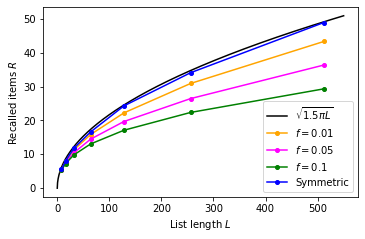

In [32]:
#Plot
xs = np.linspace(0, 550, 1000)

with mpl2latex(False): #True to enable LaTeX export
    fig, ax = plt.subplots(figsize=latex_figsize(wf=.8))

    ax.plot(xs, np.sqrt(1.5 * np.pi * xs), '-', c='black', label=r"$\sqrt{1.5\pi L}$")
    ax.plot(list_lengths, df.loc[0.01], '-o', c='orange', markersize=4, label='$f=0.01$')
    ax.plot(list_lengths, df.loc[0.05], '-o', c='magenta', markersize=4, label='$f=0.05$')
    ax.plot(list_lengths, df.loc[0.1], '-o', c='green', markersize=4, label='$f=0.1$')
    ax.plot(list_lengths, df.loc["symm"], '-o', c='blue', markersize=4, label='Symmetric')

    ax.set_xlabel("List length $L$")
    ax.set_ylabel("Recalled items $R$")

    plt.legend()
    
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.)
    
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.)
    
    plt.savefig("Plots/reco_sim.pdf", bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none') # 
    
    plt.show()